# Introdução

* O primeiro modelo que vamos utilizar será o **ARIMA - Modelo Auto Regressivo e de Média Móvel**.

* Para isso, vamos fazer uma previsão **apenas do ativo AAPL**, por enquanto. O dataset de AAPL por hora já está nesta pasta compartilhada.

* A estratégia é utilizar fazer **previsões gradativas, começando com 1h, depois 2h, e assim por diante**. E, dessa forma, verificarmos até quanto tempo de antecedência o modelo será capaz de prever com boa precisão.

* **Outros modelos serão desenvolvidos em outros notebooks**. Os resultados serão comparados à medida que forem gerados novos resultados.

# Configurações do ambiente

#### install

In [ ]:
!pip install pyyaml==5.4.1

# instalando lib que aplica indicadores traders
!pip install talib-binary

# lib para pegar preços dos ativos
!pip install yfinance

     |████████████████████████████████| 636 kB 4.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 2.4 MB 5.0 MB/s 
     |████████████████████████████████| 6.4 MB 7.8 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, b

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.9 MB/s 
     |████████████████████████████████| 9.8 MB 41.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
pip install statsmodels==0.11.0

     |████████████████████████████████| 8.7 MB 5.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.2
    Uninstalling statsmodels-0.13.2:
      Successfully uninstalled statsmodels-0.13.2


# Importando as libs

In [ ]:
# importando do Google Drive
from google.colab import drive

# bibliotecas para tratamento dos dados
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns

#import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# biblioteca modelo
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [ ]:
# removendo os avisos
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Importando os Dados (gdrive)

Segundo a fonte dos dados (Yahoo Finance), as features apresentadas possuem os seguintes significados:

*   Open: primeiro preço da unidade de tempo avaliada (hora, dia...)
*   High: maior preço durante a unidade de tempo avalidada (hora, dia...)
*   Low: menor preço durante a unidade de tempo avalidada (hora, dia...)
*   Close: preço de fechamento segundo a unidade de tempo avaliada (hora, dia...)
*   Adj Close: preço ajustado depois de splits distribuição de dividendos. Os dados são ajustados segundo os padrões estabelecidos por Center for Research in Security Prices (CRSP).



Os dados já foram baixados e estão na pasta compartilhada com o grupo.

Assim, só precisamos importar os datasets de cada ativo diretamente do drive

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# importando o dataset da AAPL por hora
df_aapl_hora = pd.read_csv('/content/gdrive/My Drive/Tera - Grupo Mercado Financeiro/Dados/df_AAPL_hora.csv')
df_aapl_hora.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df_aapl_hora['Date'] = pd.to_datetime(df_aapl_hora['Date'], utc=True)
df_aapl_hora.set_index('Date', inplace=True)

# dataset da AAPL dia - para uma visão macro
df_aapl_dia = pd.read_csv('/content/gdrive/My Drive/Tera - Grupo Mercado Financeiro/Dados/df_AAPL_dia.csv')
df_aapl_dia.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df_aapl_dia['Date'] = pd.to_datetime(df_aapl_dia['Date'], utc=True)
df_aapl_dia.set_index('Date', inplace=True)

# conferindo o tamanho do dataset
print('AAPL hora tamanho:', df_aapl_hora.shape)
print('--------------------------')
print('AAPL dia tamanho:', df_aapl_dia.shape)

AAPL hora tamanho: (2273, 6)
--------------------------
AAPL dia tamanho: (2517, 6)


# EDA (Análise exploratória de dados)

Agora que já importamos os dados, vamos fazer a análise exploratória do dataset. <br>


HIPÓTESES

*   A série temporal possui sazonalidade
*   Série temporal não estacionária (média e desvio padrão não são constantes)
*   A série possui outliers





### Avaliando dataset 

In [ ]:
# verificando informações gerais de AAPL
print('Dataset AAPL HORA\n')
print(df_aapl_hora.info())
print('\n------------------------------------\n')
print('Dataset AAPL DIA\n')
print(df_aapl_dia.info())

Dataset AAPL HORA

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2273 entries, 2021-01-04 14:30:00+00:00 to 2022-04-21 20:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2273 non-null   float64
 1   High       2273 non-null   float64
 2   Low        2273 non-null   float64
 3   Close      2273 non-null   float64
 4   Adj Close  2273 non-null   float64
 5   Volume     2273 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 124.3 KB
None

------------------------------------

Dataset AAPL DIA

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2012-04-23 00:00:00+00:00 to 2022-04-21 00:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2517 non-null   float64
 1   High       2517 non-null   float64
 2   Low        2517 non-null   float64
 3   Close      2517 non-null   float64

*   Não há dados daltantes nos datasets

In [ ]:
# verificando as primeiras linhas dos datasets
df_aapl_hora.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04 14:30:00+00:00,133.520004,133.611603,130.380005,131.053604,131.053604,27653145
2021-01-04 15:30:00+00:00,131.054993,131.309998,129.399994,129.895004,129.895004,20134055
2021-01-04 16:30:00+00:00,129.889893,130.089996,126.760002,128.250000,128.250000,23694210
2021-01-04 17:30:00+00:00,128.246902,129.110001,127.630096,129.039795,129.039795,14745063
2021-01-04 18:30:00+00:00,129.039993,129.199997,128.595001,128.960007,128.960007,10861778


In [ ]:
# verificando as primeiras linhas dos datasets
df_aapl_dia.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-04-23 00:00:00+00:00,20.378929,20.595358,19.879286,20.417856,17.483290,966529200
2012-04-24 00:00:00+00:00,20.093214,20.274643,19.821428,20.010000,17.134043,1076149200
2012-04-25 00:00:00+00:00,21.987143,22.071428,21.642857,21.785713,18.654541,905777600
2012-04-26 00:00:00+00:00,21.938213,21.953215,21.504642,21.703571,18.584202,536068400
2012-04-27 00:00:00+00:00,21.609644,21.649286,21.446428,21.535713,18.440470,406722400


### Plot do dataset

*   Para evitar dados errôneos devido a splits e distribuição de dividendos, vamos utilizar a feature Adj Close, que já considera essas questões

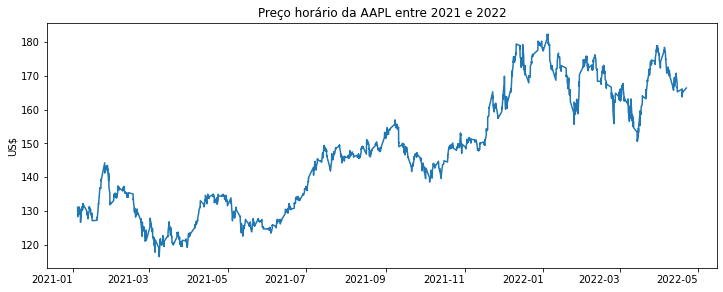

In [ ]:
# plotando a variação de preço do ativo por hora
ax = df_aapl_hora['Adj Close'].plot(figsize=(12,5))
plt.title('Preço horário da AAPL entre 2021 e 2022')
plt.xlabel('')
plt.ylabel('US$')
plt.tick_params(rotation = 0)

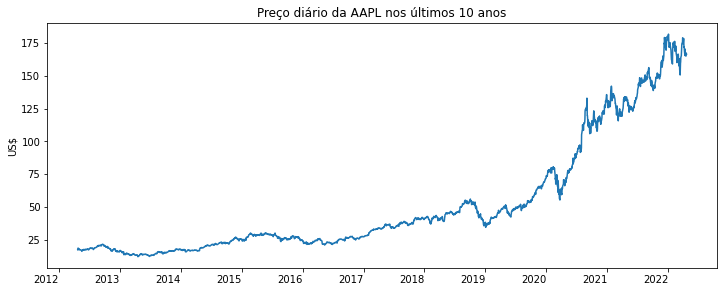

In [ ]:
# plotando a variação de preço do ativo por dia
ax = df_aapl_dia['Adj Close'].plot(figsize=(12,5))
plt.title('Preço diário da AAPL nos últimos 10 anos')
plt.xlabel('')
plt.ylabel('US$')
plt.tick_params(rotation = 0)

Text(0.5, 0, 'Adj Close DIA')

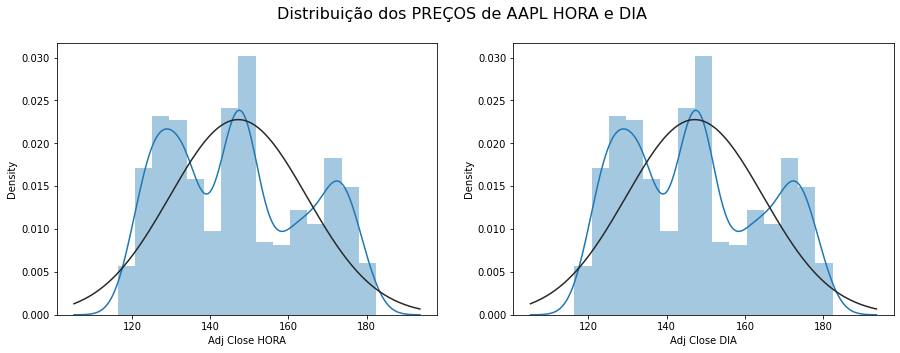

In [ ]:
# plotando as distribuições dos preços, por DIA E HORA

fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Distribuição dos PREÇOS de AAPL HORA e DIA", fontsize=16)
ax1 = sns.distplot(df_aapl_hora['Adj Close'],
                   fit=norm,
                   kde=True,
                   ax=axs[0])
ax1.set_xlabel('Adj Close HORA')
ax2 = sns.distplot(df_aapl_hora['Adj Close'],
                   fit=norm,
                   kde=True,
                   ax=axs[1])
ax2.set_xlabel('Adj Close DIA')

*   Pelo plot de variação do preço por hora, podemos perceber que a série não parece estacionária, o que era esperado, por ser um ativo.

### Sazonalidade

*   Agora, vamos analisar a sazonalidade mensal do mesmo ativo. Para isso, precisamos agrupar a série em valores mensais. Assim, utilizaremos o método resample.

In [ ]:
# agrupando os valores diários em mensais
df_aapl_mes = df_aapl_dia.resample('M').last()

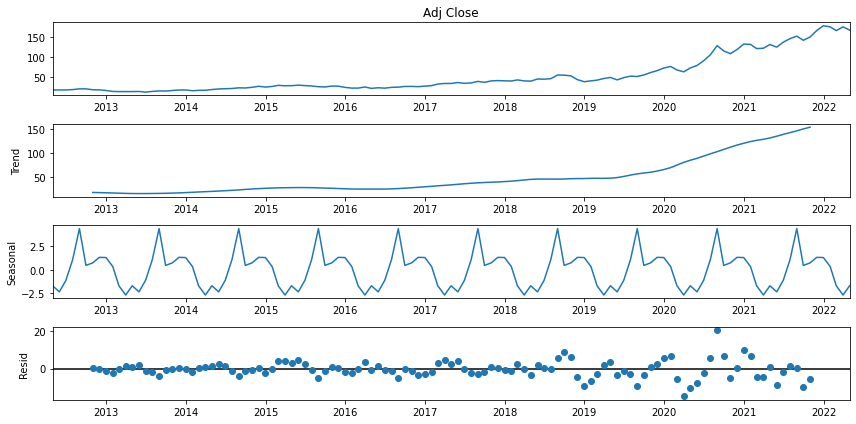

In [ ]:
# fazendo a decomposição mensal
decomposicao_aapl = seasonal_decompose(df_aapl_mes['Adj Close'], model='additive')
fig = decomposicao_aapl.plot()
fig.set_size_inches((12, 6))
# Tight layout to realign things
fig.tight_layout()
plt.show()

*   Nota-se, pelo gráfico acima, que há componente de sazonalidade na nossa série temporal.

### Série Estacionaria?

Agora, vamos analisar se a **série é estacionária, ou não**. Para que seja, ela precisa ter a média e a variância constantes no tempo, além de ter correlação entre 2 períodos constante
*   Vamos utilizar o **teste de Dickey Fuller** para verificar se nossa série é estacionária ou não.
*   **H0 -> Série não estacionária (p-value > 0.05)**
*   **H1 -> Série estacionária (p-value <= 0.05)**

In [ ]:
# rodando o método de Dickey Fuller

adfuller_aapl_hora = adfuller(df_aapl_hora['Adj Close'])
adfuller_aapl_dia = adfuller(df_aapl_dia['Adj Close'])
print('ADF Statistics AAPL HORA:', adfuller_aapl_hora[0])
print('p-value AAPL HORA:', adfuller_aapl_hora[1])
print('------------------------------')
print('ADF Statistics AAPL DIA:', adfuller_aapl_dia[0])
print('p-value AAPL DIA:', adfuller_aapl_dia[1])

ADF Statistics AAPL HORA: -1.2372893665712357
p-value AAPL HORA: 0.6573526804673867
------------------------------
ADF Statistics AAPL DIA: 1.6876796006879642
p-value AAPL DIA: 0.9980981688255074




*   Para ambos os datasets (AAPL hora e AAPL dia) o resultado estatístico mostrou que **as séries não são estacionárias**. (p-value > 0.05)



### Média Móvel

A partir daqui, podemos utilizar somente o dataset de horas, uma vez que vamos fazer previsões horárias

A média móvel vai ser útil tanto para efeito comparativo das métricas do futuro modelo, quanto para identificação de outliers, por 3-sigmas (3 desvios padrão)

In [ ]:
# calculando média móvel do dataset HORAS (janela de 8 horas)
df_aapl_hora['media_movel'] = df_aapl_hora['Adj Close'].rolling(8).mean()

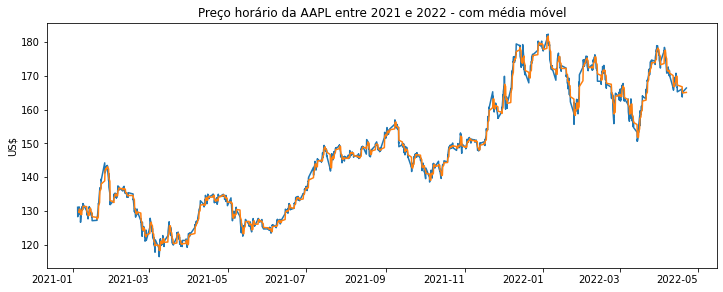

In [ ]:
# plotando a variação de preço do ativo por hora
df_aapl_hora['Adj Close'].plot(figsize=(12,5))
df_aapl_hora['media_movel'].plot()
plt.title('Preço horário da AAPL entre 2021 e 2022 - com média móvel')
plt.xlabel('')
plt.ylabel('US$')
plt.tick_params(rotation = 0)

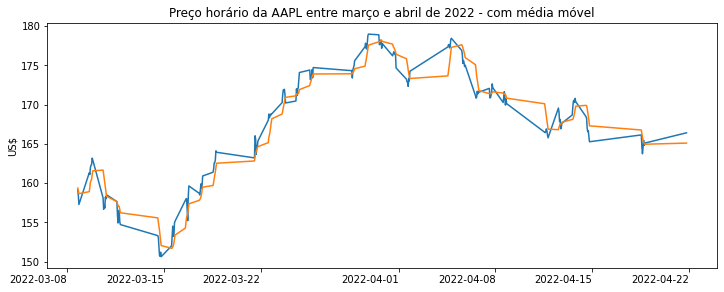

In [ ]:
# plotando a variação de preço do ativo por hora - últimos 200 dados
df_aapl_hora['Adj Close'][-200:].plot(figsize=(12,5))
df_aapl_hora['media_movel'][-200:].plot()
plt.title('Preço horário da AAPL entre março e abril de 2022 - com média móvel')
plt.xlabel('')
plt.ylabel('US$')
plt.tick_params(rotation = 0)

### Identificando Outliers

Os outliers serão considerados através de 3 desvios padrão. Dessa forma, o primeiro passo é calcular o desvio padrão móvel. Para isso, vamos utilizar o método Rolling, como para a média móvel

In [ ]:
# calculando desvio padrão móvel do dataset HORAS (janela de 8 horas)
df_aapl_hora['std_movel'] = df_aapl_hora['Adj Close'].rolling(8).std()

In [ ]:
# identificando outliers

outliers_hora = []
upper_aapl = []
lower_aapl = []

# outliers no dataset de horas
for x, mm, sigma in list(zip(df_aapl_hora['Adj Close'],df_aapl_hora['media_movel'],df_aapl_hora['std_movel'])):
  if (x > mm + 3*sigma) | (x < mm - 3*sigma):
    outliers_hora.append('outlier')
  else:
    outliers_hora.append('intlier')
  upper = mm + 3*sigma
  low = mm - 3*sigma
  upper_aapl.append(upper)
  lower_aapl.append(low)

df_aapl_hora['outliers'] = outliers_hora
df_aapl_hora['upper_limit'] = upper_aapl
df_aapl_hora['lower_limit'] = lower_aapl

In [ ]:
# removendo dados nulos
df_aapl_hora.dropna(inplace=True)

CPU times: user 73.4 ms, sys: 241 µs, total: 73.6 ms
Wall time: 74.1 ms


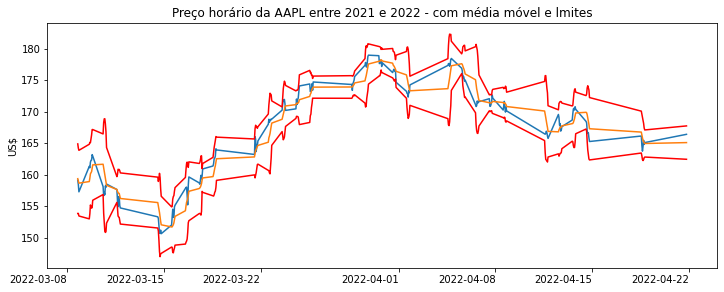

In [ ]:
%%time
# plotando a variação de preço do ativo e os limites superior e inferior
df_aapl_hora['Adj Close'][-200:].plot(figsize=(12,5))
df_aapl_hora['media_movel'][-200:].plot()
df_aapl_hora['upper_limit'][-200:].plot(color='red')
df_aapl_hora['lower_limit'][-200:].plot(color='red')

plt.title('Preço horário da AAPL entre 2021 e 2022 - com média móvel e lmites')
plt.xlabel('')
plt.ylabel('US$')
plt.tick_params(rotation = 0)

In [ ]:
print('Quantidade de outliers AAPL HORA:', (df_aapl_hora['outliers']=='outlier').sum())

Quantidade de outliers AAPL HORA: 0


*   Não há outliers no datasets de AAPL por horas

### Conclusões da EDA

* Nossa série de Adj Close da AAPL horaria apresenta uma **série não estacionária**
* Como mostrado pelos dados agrupados mensalmente, **a série possui sazonalidade**
* **Não há outliers na série** (outliers considerados com média móvel +/- 3*sigma móvel)

# Escolhendo o MODELO

Vamos utilizar o método ARIMA como primeiro modelo de previsão. Para isso, devemos definir 3 parâmetros que serão utilizados: p, q e d.

*   **d**: número de **diferenciações** até que a série se torne estacionária.
*   **p**: ordem do termo de **AR -> lag's de PACF**
*   **q**: ordem do termo de **MA -> lag's de ACF**

FONTE: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

Artigos para estudar ARIMA

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://medium.com/@lumeilin301/predict-stock-prices-using-arima-in-python-432bce506ddc

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.youtube.com/watch?v=gqryqIlvEoM

https://www.youtube.com/watch?v=JMT1eGJ9c2M

### Cálculo Retorno Percentual - Diferenciações (d)

* Como vimos durante a EDA, **nossa série é não estacionária**. Dessa forma, precisamos verificar a **quantidade de diferenciações** serão necessárias até torna-la estacionária. Essa quantidade de diferenciações será o nosso **parêmtro d do ARIMA**

In [ ]:
# Calculo do retorno percentual (1º diferenciação)
df_aapl_hora['return_percent'] = df_aapl_hora['Adj Close'].pct_change()
df_aapl_hora.dropna(inplace=True)

Text(0.5, 1.0, 'Distribuição dos retornos (1º Diferenciação)')

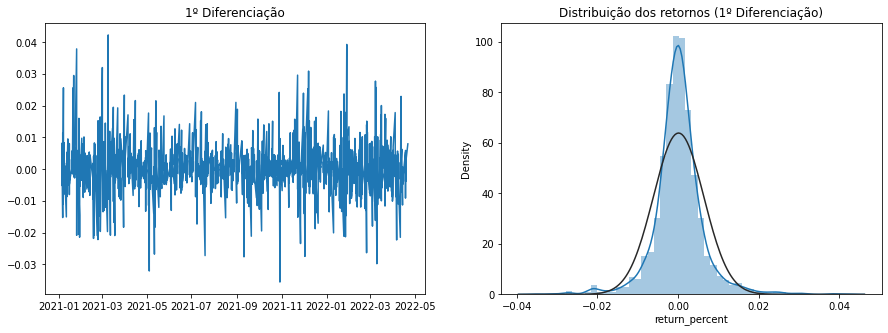

In [ ]:
# verificando as distribuições dos retornos por HORA
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(df_aapl_hora['return_percent'])
axs[0].set_title('1º Diferenciação')

ax2 = sns.distplot(df_aapl_hora['return_percent'],
                   fit=norm,
                   kde=True,
                   ax=axs[1])
ax2.set_title('Distribuição dos retornos (1º Diferenciação)')

Text(0.5, 1.0, 'Distribuição da amostra comparado com teórico')

<Figure size 576x288 with 0 Axes>

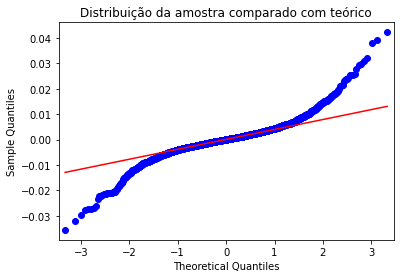

In [ ]:
# comparando probabilidades de distribuições
# entre teórico e a amostra
plt.figure(figsize=(8,4))
qq1 = sm.qqplot(df_aapl_hora['return_percent'],
                line = 'q')
plt.title('Distribuição da amostra comparado com teórico')

In [ ]:
# rodando o método de Dickey Fuller para retorno PERCENTUAL

adfuller_aapl_hora = adfuller(df_aapl_hora['return_percent'])
print('ADF Statistics AAPL HORA:', adfuller_aapl_hora[0])
print('p-value AAPL HORA:', adfuller_aapl_hora[1])

ADF Statistics AAPL HORA: -8.856659061240595
p-value AAPL HORA: 1.5214597754619203e-14


*   Pelos plots das distribuições da 1º diferenciação (retorno percentual), podemos perceber que a série parece estacionária, com heavy tail (segundo o q-q plot)
*   Após aplicação do método de Dickey Fuller, concluímos que a **1º diferenciação** foi o suficiente para tornar a **série estacionária**
* Portanto, nosso **parâmetro d do ARIMA é 1**

### Teste Normalidade

Agora, podemos verificar se as distribuições de retorno são normais ou não.

Para isso, vamos utilizar o método de shapiro, da lib scipy stats

In [ ]:
# Para o DATASET de HORAS
# testando normalidade do retorno PERCENTUAL
print('Dataset HORAS, retorno PERCENTUAL (1º dif.):', stats.shapiro(df_aapl_hora['return_percent']))

Dataset HORAS, retorno PERCENTUAL (1º dif.): (0.9016091227531433, 6.922607053067084e-36)


*   Como o **p-valor é menor que 0.05**, temos que **a distribuição é normal**
*   Como vimos que a 1º dif. foi suficiente para transformar a série em estacionária e normal, vamos considerar somente esta diferenciação na continuidade do projeto

### PACF - Função de Autocorrelação Parcial (p)

In [ ]:
df_aapl_hora.head()

,Open,High,Low,Close,Adj Close,Volume,media_movel,std_movel,outliers,upper_limit,lower_limit,return_percent
Date,,,,,,,,,,,,
2021-01-05 15:30:00+00:00,131.070007,131.419296,129.929993,130.380005,130.380005,14752547,129.507103,0.894237,intlier,132.189814,126.824392,-0.005128
2021-01-05 16:30:00+00:00,130.374893,130.679993,129.839996,130.149902,130.149902,10321153,129.538965,0.914348,intlier,132.282008,126.795923,-0.001765
2021-01-05 17:30:00+00:00,130.145004,130.339996,129.850006,130.044998,130.044998,6214402,129.763340,0.760085,intlier,132.043595,127.483085,-0.000806
2021-01-05 18:30:00+00:00,130.040802,131.250000,130.039993,131.110001,131.110001,9688012,130.022116,0.827938,intlier,132.505928,127.538303,0.008189
2021-01-05 19:30:00+00:00,131.110001,131.404999,130.815002,130.830002,130.830002,8923737,130.255865,0.745066,intlier,132.491062,128.020669,-0.002136


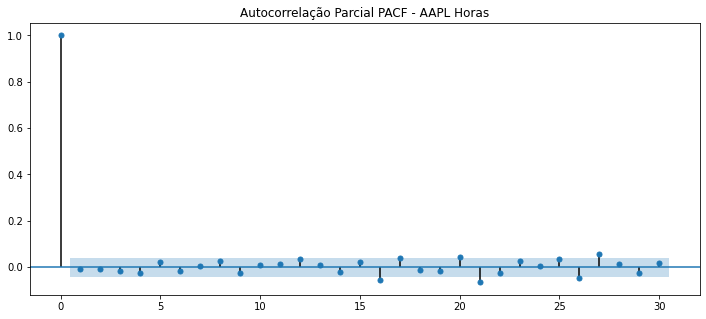

In [ ]:
# plotando PACF para df HORAS
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(df_aapl_hora['return_percent'].dropna(), lags = 30, ax=ax)
ax.set_title('Autocorrelação Parcial PACF - AAPL Horas')
plt.show()

*   Somente uma lag (dado anterior) está acima da linha significativa. Então, vamos definir **p = 1**



### ACF - Função de Autocorrelação (q)

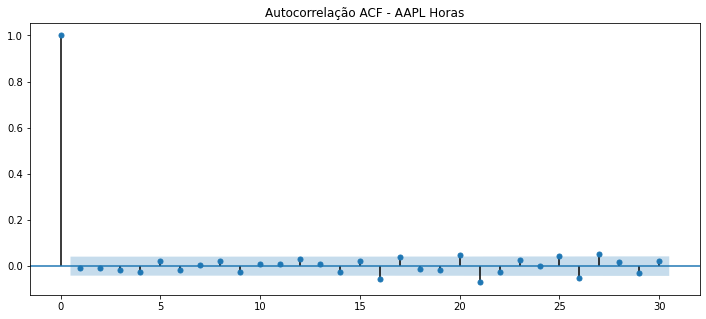

In [ ]:
# plotando ACF para df HORAS
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(df_aapl_hora['return_percent'].dropna(), lags = 30, ax=ax)
ax.set_title('Autocorrelação ACF - AAPL Horas')
plt.show()

* Somente uma lag (dado anterior) está acima da linha significativa. Então, vamos definir **q = 1**

# MODELO ARIMA

* Segundo o desenvolvido durante as etapas anteriores, temos os seguintes valores para os parâmetros do ARIMA: **p=1, d=1 e q=1**

In [ ]:
%%time
# 27,1,27 ARIMA Model
model = ARIMA(df_aapl_hora['Adj Close'], order=(16,1,16))
model_fit = model.fit(disp=0)
#modelo = sm.tsa.arima.ARIMA(df_aapl_hora['Adj Close'], order=(4,1,3))
#model_fit = modelo.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 2264
Model:               ARIMA(16, 1, 16)   Log Likelihood               -2999.358
Method:                       css-mle   S.D. of innovations              0.909
Date:                Fri, 13 May 2022   AIC                           6066.716
Time:                        19:58:49   BIC                           6261.363
Sample:                             1   HQIC                          6137.739
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0144      0.019      0.751      0.452      -0.023       0.052
ar.L1.D.Adj Close     -0.7887        nan        nan        nan         nan         nan
ar.L2.D.Adj Close   

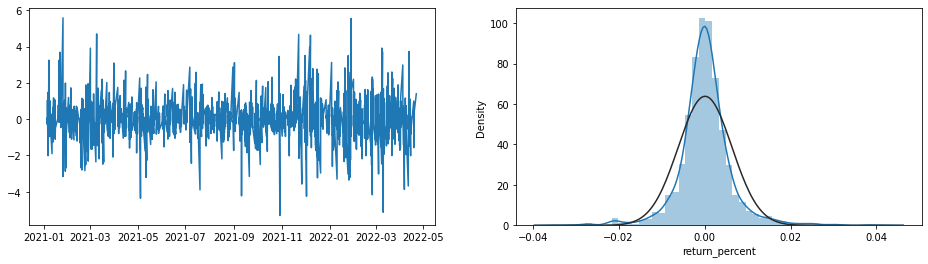

In [ ]:
# plot residuos
residuals = pd.DataFrame(model_fit.resid)

fig, (ax1, ax2) = plt.subplots( 1, 2, figsize = (16, 4))

ax1.plot(residuals)
sns.distplot(df_aapl_hora['return_percent'],
                   fit=norm,
                   kde=True,
                   ax=ax2)

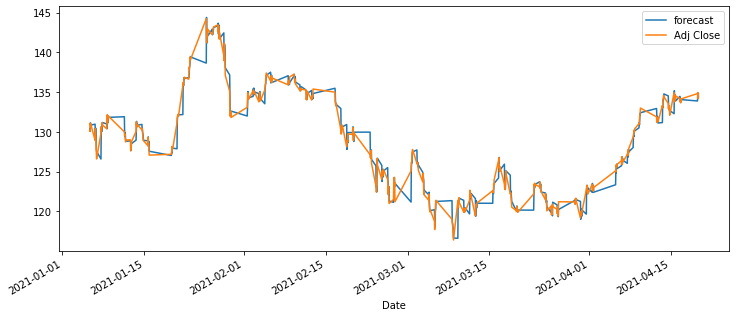

In [ ]:
# real vs previsto
fig, ax = plt.subplots(figsize=(12, 5))
model_fit.plot_predict(start = 1,
                       end = 500,
                       dynamic = False,
                       ax = ax)
plt.show()

### Divisão entre Treino e Teste 90:10

In [ ]:
# dividindo em treino e teste, na proporção de 95:5
n = int(len(df_aapl_hora)*0.95)
#n= 2263
train_aapl_hora = df_aapl_hora['Adj Close'][:n]
test_aapl_hora = df_aapl_hora['Adj Close'][n:]

print(len(train_aapl_hora))
print(len(test_aapl_hora))

2151
114


### Treino do modelo

In [ ]:
%%time
# 16,1,16 ARIMA Model
model = ARIMA(train_aapl_hora, order=(2,1,2))
model_fit = model.fit(disp=0)

model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


CPU times: user 1.23 s, sys: 195 ms, total: 1.42 s
Wall time: 1.25 s


### Teste e resultados

In [ ]:
# verificando os resultados
step = len(test_aapl_hora)

# fc (forecast), se ()
fc, se, conf = model_fit.forecast(step)

In [ ]:
model_fit.predict(start=1,end=100)

Date
2021-01-05 16:30:00+00:00    0.019913
2021-01-05 17:30:00+00:00    0.027280
2021-01-05 18:30:00+00:00    0.021597
2021-01-05 19:30:00+00:00   -0.015610
2021-01-05 20:30:00+00:00    0.043699
                               ...   
2021-01-25 20:30:00+00:00   -0.027863
2021-01-26 14:30:00+00:00   -0.016992
2021-01-26 15:30:00+00:00    0.117803
2021-01-26 16:30:00+00:00   -0.087527
2021-01-26 17:30:00+00:00    0.096195
Length: 100, dtype: float64

In [ ]:
fc = pd.Series(fc, index = test_aapl_hora[:step].index)
lower = pd.Series(conf[:,0], index = test_aapl_hora[:step].index)
upper = pd.Series(conf[:,1], index = test_aapl_hora[:step].index)

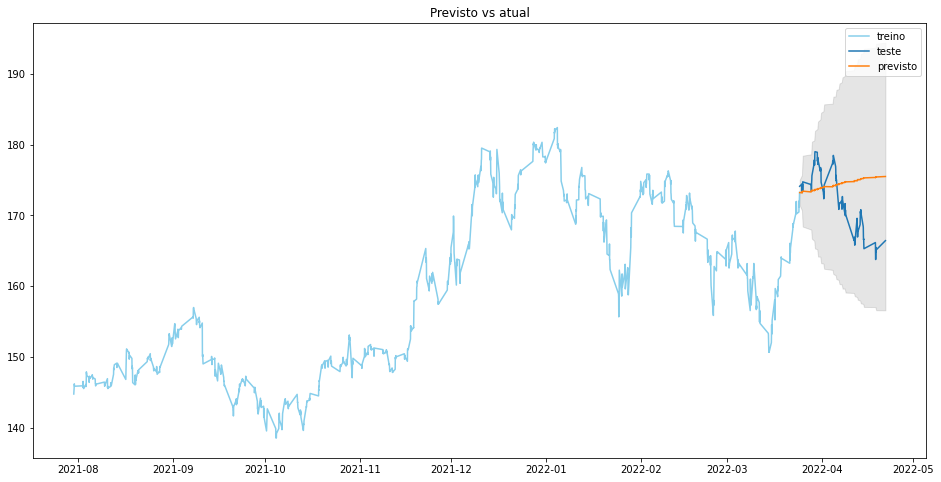

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(train_aapl_hora[1000:], label = 'treino', color='skyblue')
plt.plot(test_aapl_hora[:step], label = 'teste')
plt.plot(fc, label='previsto')
plt.fill_between(lower.index, lower, upper, color = 'k', alpha = 0.1)
plt.title('Previsto vs atual')
plt.legend(loc='best')

# MODELO ARIMA - Step by step (sbs)

Agora, vamos testar uma outra estratégia.

Vamos tentar prever apenas o próximo valor, e depois alimentar nosso treino com esse próximo valor real.

Dessa forma, vamos precisar de um loop, que a cada iteração, primeiro treina o modelo com dados de treino, depois tenta prever 1 valor e ao final, alimenta a base de treino com esse próximo valor real.

## Teste com valores conhecidos

In [ ]:
# dividindo em treino e teste, na proporção de 95:5
n = int(len(df_aapl_hora)*0.95)
#n=2263
train_aapl_hora_sbs = df_aapl_hora['Adj Close'][:n]
test_aapl_hora_sbs = df_aapl_hora['Adj Close'][n:]

In [ ]:
%%time
tamanho_teste=len(test_aapl_hora_sbs)
fc_sbs = []

for i in range(tamanho_teste):
  # 2,1,2 ARIMA Model
  train_aapl_hora_sbs = df_aapl_hora['Adj Close'][:n+i]
  model_sbs = ARIMA(train_aapl_hora_sbs, order=(2,1,2))
  model_sbs_fit = model_sbs.fit(disp=0)

  # forecast o próximo valor
  fc, se, conf = model_sbs_fit.forecast(1)
  # armazena na nossa lista
  fc_sbs.append(fc[0])

# transformando os valores previsto em uma série
# com o mesmo index da série de teste
forecast_sbs = pd.Series(fc_sbs, index = test_aapl_hora.index)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

CPU times: user 2min 45s, sys: 21.9 s, total: 3min 7s
Wall time: 2min 49s


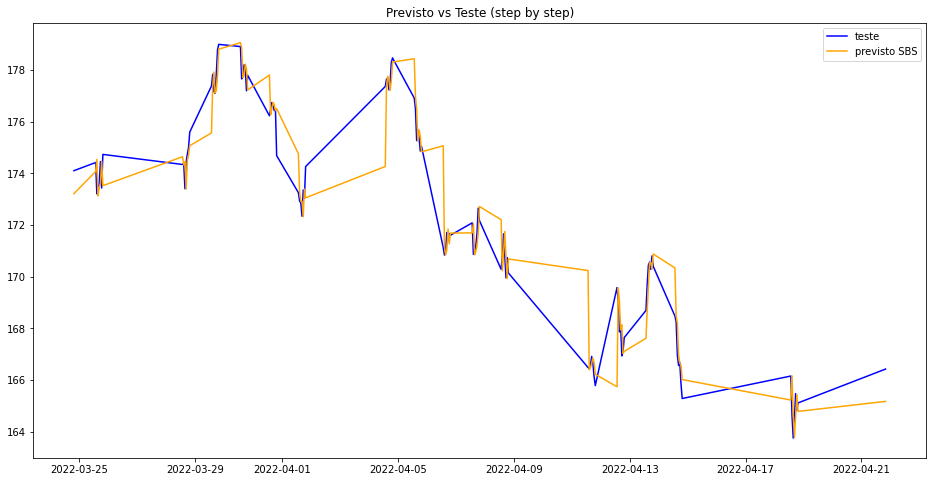

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(test_aapl_hora[:step], label = 'teste', color = 'blue')
plt.plot(forecast_sbs, label='previsto SBS', color = 'orange')
plt.title('Previsto vs Teste (step by step)')
plt.legend(loc='best')

In [ ]:
tamanho_teste=len(test_aapl_hora_sbs)

range(tamanho_teste)

range(0, 114)

## Teste com valores novos

In [ ]:
#df até abril
df_treino_novo = df_aapl_hora['Adj Close']

In [ ]:
# teste com valores mais recentes
# importando os dados
# importando o dataset da AAPL por hora
df_AAPL_hora_teste = pd.read_csv('/content/gdrive/My Drive/Tera - Grupo Mercado Financeiro/Dados/df_AAPL_hora_teste.csv')
df_AAPL_hora_teste.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df_AAPL_hora_teste['Date'] = pd.to_datetime(df_AAPL_hora_teste['Date'], utc=True)
df_AAPL_hora_teste.set_index('Date', inplace=True)

In [ ]:
# selecionando só os100 primeiros
df_AAPL_hora_teste = df_AAPL_hora_teste['Adj Close'][:100]
df_AAPL_hora_teste

Date
2022-04-22 13:30:00+00:00    165.479996
2022-04-22 14:30:00+00:00    165.929993
2022-04-22 15:30:00+00:00    164.631302
2022-04-22 16:30:00+00:00    164.070007
2022-04-22 17:30:00+00:00    163.475601
                                ...    
2022-05-11 16:30:00+00:00    148.559998
2022-05-11 17:30:00+00:00    147.370102
2022-05-11 18:30:00+00:00    146.559998
2022-05-11 19:30:00+00:00    146.589996
2022-05-13 20:00:00+00:00    147.110001
Name: Adj Close, Length: 99, dtype: float64

In [ ]:
%%time
tamanho_teste=len(df_AAPL_hora_teste)
fc_sbs = []

for i in range(tamanho_teste):
  # 2,1,2 ARIMA Model
  train_aapl_hora_sbs = pd.concat([df_treino_novo,df_AAPL_hora_teste[:i]])
  model_sbs = ARIMA(train_aapl_hora_sbs, order=(2,1,2))
  model_sbs_fit = model_sbs.fit(disp=0)

  # forecast o próximo valor
  fc, se, conf = model_sbs_fit.forecast(1)
  # armazena na nossa lista
  fc_sbs.append(fc[0])

# transformando os valores previsto em uma série
# com o mesmo index da série de teste
forecast_sbs = pd.Series(fc_sbs, index = df_AAPL_hora_teste.index)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWa

CPU times: user 3min 36s, sys: 21.2 s, total: 3min 58s
Wall time: 3min 40s


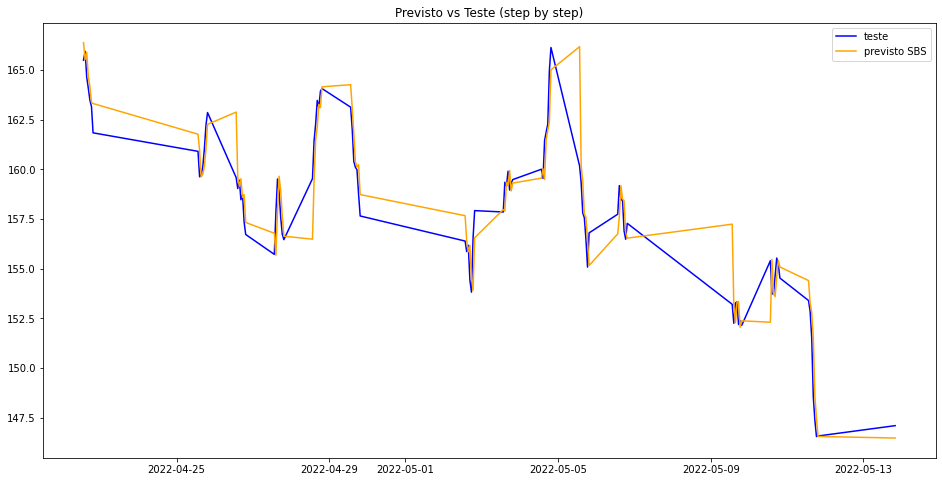

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df_AAPL_hora_teste[:tamanho_teste], label = 'teste', color = 'blue')
plt.plot(forecast_sbs, label='previsto SBS', color = 'orange')
plt.title('Previsto vs Teste (step by step)')
plt.legend(loc='best')

# AUTO ARIMA

Podemos encontrar os melhoes parâmetros através do auto arima também.

Esse método roda diversas combinações e retorna a melhor.

In [ ]:
auto_arima_aapl = auto_arima(df_aapl_hora['Adj Close'],
                             start_p=0, start_q=0,
                             max_p=5, max_q=5,
                             trace = True,
                             suppress_warnings = True)
auto_arima_aapl.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6084.046, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6086.041, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6086.040, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6082.714, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6088.040, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.078 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2265
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3040.357
Date:                Thu, 28 Apr 2022   AIC                           6082.714
Time:                        09:30:35   BIC                           6088.439
Sample:                             0   HQIC                          6084.803
                               - 2265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.8589      0.012     68.904      0.000       0.835       0.883
===================================================================================
Ljung-Box (Q):                       91.85   Jarque-Bera (JB):              3852.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""